#### Classification on Spiral Dataset

This notebook contains classification on a spiral dataset using the following methods:
- k nearest neighbors (Scikit-learn)
- SVM with Gaussian radial basis function (Scikit-learn)
- multi-layer neural network (TensorFlow)

In [1]:
import numpy as np
import tensorflow as tf
from sklearn import neighbors
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

# set parameters for plots
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def generate_data(N=100, n_dim=2, n_class=3):
    """Generate spiral dataset."""
    X = np.zeros((N*n_class, n_dim)) # data matrix
    y = np.zeros(N*n_class, dtype="uint8") # class labels
    for j in range(n_class):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.5 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y


def get_batch(epoch, batch, batch_size):
    """Generates random batch from data."""
    np.random.seed(epoch * N_BATCHES + batch)
    indices = np.random.randint(N*N_CLASS, size=batch_size)
    x_batch = X[indices]
    y_batch = y[indices]
    return x_batch, y_batch


def compute_accuracy(model, X, y):
    """Computes model accuracy in classifying data points."""
    # use trained model to get predicted class for each data point
    preds = model.predict(X)
    # count number of instances where prediction = actual class label
    n_correct = np.sum(preds == y)
    accuracy = n_correct / X.shape[0]
    return accuracy


def nn_layer(inputs, n_neurons):
    """Creates layer in neural network and ReLU activation"""
    n_inputs = int(inputs.get_shape()[1])
    # define weight and bias variables with n_neurons units
    W = tf.Variable(tf.truncated_normal((n_inputs, n_neurons), name="W"))
    b = tf.Variable(tf.zeros([n_neurons]), name="b")
    z = tf.matmul(inputs, W) + b
    return tf.nn.relu(z)
    

def generate_mesh(X, y):
    """Generates data to be used in mesh grid"""
    h = 0.01 # step size in mesh grid

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy, np.c_[xx.ravel(), yy.ravel()]
    

def plot_data(X, y, model=None, mesh=False, 
              title="Spiral Data", use_nn=False, nn_preds=None):
    """Plots data points and decision boundaries using trained model."""

    plt.figure()    
    if mesh: # plot mesh if making predictions
        xx, yy, mesh_data = generate_mesh(X, y)
        if use_nn:
            # use predictions from neural net model
            Z = nn_preds
        else:
            # use predictions from non-neural net model
            Z = model.predict(mesh_data)

        Z = Z.reshape(xx.shape)
        # plot decision boundaries from model
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
        
    # plot data set points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolors='black', cmap=plt.cm.Spectral)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()

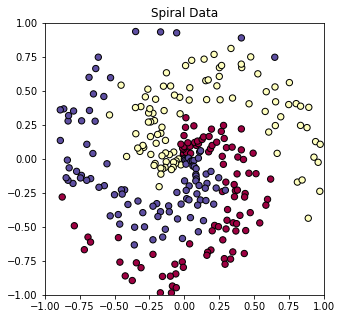

In [3]:
# parameters for data generation
N = 100 # number of points per class
N_DIM = 2 # dimensionality
N_CLASS = 3 # number of classes

# generate and plot spiral dataset
X, y = generate_data(N, N_DIM, N_CLASS)
plot_data(X, y)

#### k nearest neighbors

The nearest neighbors algorithm classifies a data point by: finding the k nearest data points; using each of these points to vote for its respective class; assigning the data point to class with the most votes. The voting can use uniform weights for each points or a distance weight, where closer neighbors are given more weight. Both methodologies are displayed below.

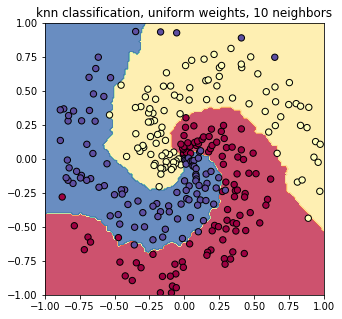

accuracy with uniform weights: 0.950


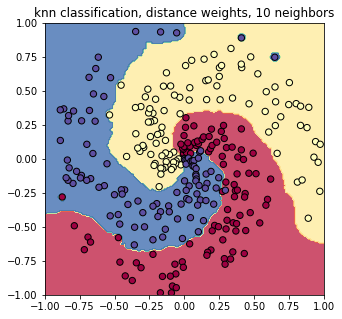

accuracy with distance weights: 0.993


In [4]:
# number of neighbors
K = 10
# weight_type="uniform": each neighbor vote is equally weighted
# weight_type="distance": closer neighbors given more weight
weight_type = ['uniform', 'distance']

for weight in weight_type:
    # create and fit knn model
    knn = neighbors.KNeighborsClassifier(K, weights=weight)
    knn.fit(X, y)
    
    plot_data(X, y, knn, mesh=True,
              title='knn classification, {0} weights, {1} neighbors'.format(weight, K))
    accuracy = compute_accuracy(knn, X, y)
    print('accuracy with {0} weights: {1:.3f}'.format(weight, accuracy))

#### SVM with Gaussian radial basis function

SVM creates a decision boundary to seperate classes. A linear decision boundary will clearly not be accurate with this non-linear dataset. Instead we use a non-linear kernel (Gaussian Radial Basis Function kernel) to transform the data to a high-dimensional space where an linear separation is more likely.

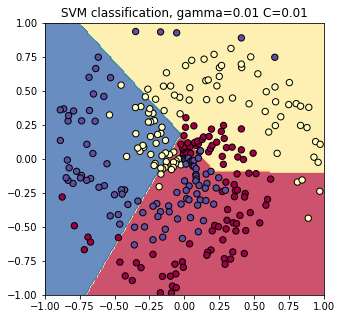

accuracy with gamma=0.01, C=0.01: 0.513


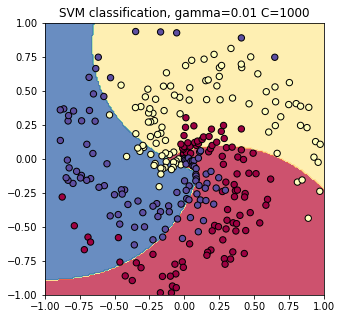

accuracy with gamma=0.01, C=1000: 0.653


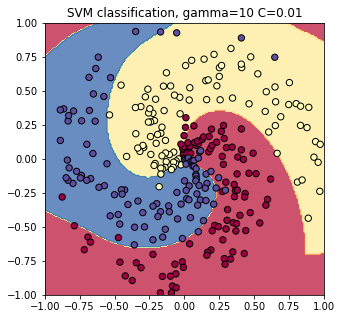

accuracy with gamma=10, C=0.01: 0.877


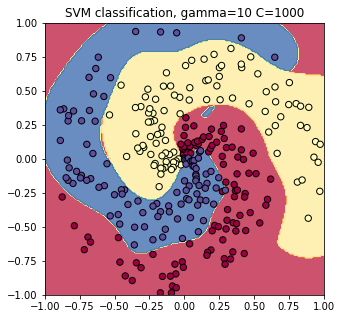

accuracy with gamma=10, C=1000: 0.987


In [5]:
# params of the form (gamma, C), where gamma is used in Gaussian RBF
# and C acts as regularizer
PARAMS = [(0.01, 0.01), (0.01, 1000), (10, 0.01), (10, 1000)]

for g, c in PARAMS:
    # create and fit svm model
    svm = SVC(kernel="rbf", gamma=g, C=c)
    svm.fit(X, y)

    plot_data(X, y, svm, mesh=True,
              title='SVM classification, gamma={0} C={1}'.format(g, c))
    accuracy = compute_accuracy(svm, X, y)
    print('accuracy with gamma={0}, C={1}: {2:.3f}'.format(
        g, c, accuracy))

High value of C results in fewer margin violations but possible overfitting. Higher value for gamma results in more irregular decision boundary which also can lead to overfitting. Can play around with these parameters until an appropriate decision boundary is achieved, i.e. balancing keeping margin as wide as possible while limiting margin violations

#### Neural network

Fitting a two layer neural network.

In [6]:
# define parameters for model and training
N_HIDDEN = 100 # size of hidden layer(s)
LEARNING_RATE = 0.01
N_EPOCHS = 500
BATCH_SIZE = 50
N_BATCHES = N_EPOCHS // BATCH_SIZE

In [7]:
tf.reset_default_graph()

# define placeholder to feed in data (add _ to avoid name conflict above)
X_ = tf.placeholder(tf.float32, shape=(None, N_DIM), name='X')
y_ = tf.placeholder(tf.int64, shape=(None), name='y')

# use name scopes to make Tensorboard graph pretty :)
with tf.name_scope('nn'):
    # create layers of neural network
    layer1 = nn_layer(X_, N_HIDDEN)
    layer2 = nn_layer(layer1, N_HIDDEN)
    logits = nn_layer(layer2, N_CLASS)
with tf.name_scope('loss'):
    # calculate cross entropy loss
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=logits), 
        name='loss')
with tf.name_scope('optimize'):
    # use vanilla gradient descent optimizer
    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    train_op = optimizer.minimize(loss)
with tf.name_scope('eval'):
    # check nn prediction by comparing highest logit class to target
    correct = tf.nn.in_top_k(logits, y_, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [8]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(N_EPOCHS):
        # create total loss and accuracy variables
        total_loss, total_acc = 0, 0
        # iterate through each batch
        for batch in range(N_BATCHES):
            # get random batch
            x_batch, y_batch = get_batch(epoch, batch, BATCH_SIZE)
            # run training op and return loss and accuracy
            _, loss_batch, accuracy_batch = sess.run([train_op, loss, accuracy], 
                                            feed_dict={X_: x_batch, y_: y_batch})
            total_loss += loss_batch
            total_acc += accuracy_batch
        if epoch % 50 == 0:
            print('Epoch {0}, Loss: {1:.2f}, Accuracy: {2:.2f}'.format(
                epoch, total_loss/N_BATCHES, total_acc/N_BATCHES))
            
    # get data for creating decision boundary plots
    _, _, mesh_data = generate_mesh(X, y)
    # feed 'dummy_y' into graph, though this will not be used
    dummy_y = np.argmax(mesh_data, axis=1)
    logits = sess.run(logits, feed_dict={X_: mesh_data, y_: dummy_y})

Epoch 0, Loss: 6.20, Accuracy: 0.46
Epoch 50, Loss: 0.14, Accuracy: 0.96
Epoch 100, Loss: 0.04, Accuracy: 0.98
Epoch 150, Loss: 0.05, Accuracy: 0.98
Epoch 200, Loss: 0.04, Accuracy: 0.99
Epoch 250, Loss: 0.07, Accuracy: 0.97
Epoch 300, Loss: 0.06, Accuracy: 0.98
Epoch 350, Loss: 0.04, Accuracy: 0.99
Epoch 400, Loss: 0.05, Accuracy: 0.99
Epoch 450, Loss: 0.03, Accuracy: 0.99


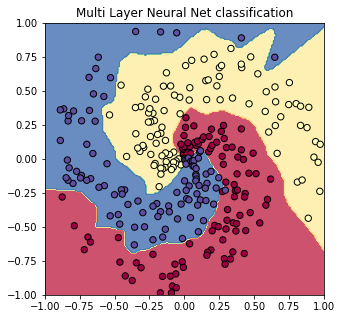

In [9]:
# get predicted class for each point
nn_preds = np.argmax(logits, axis=1)
plot_data(X, y, svm, mesh=True,
          title='Multi Layer Neural Net classification'.format(g, c),
          use_nn=True, nn_preds=nn_preds)

Two layer neural network is a bit overkill on this data set and is overfitting. Some tuning of the hyperparameters + regularization + early stopping etc can help with this. Keeping at two layers as this is more for instructive purposes.